In [1]:
%load_ext autoreload
%autoreload 2



In [43]:
import numpy as np
import pandas as pd
from simulator import LungCancerProgressionGenerator

# Generate datasets for both scenarios
generator = LungCancerProgressionGenerator(num_patients=100000, doubling_time=400)
df_without_test = generator.generate_dataset(use_blood_test=False)
df_with_test = generator.generate_dataset(use_blood_test=True)

# Function to calculate and print statistics
def print_statistics(df, scenario):
    print(f"\nStatistics for {scenario}:")
    print(f"Total number of diagnosed patients: {df['sample_id'].nunique()}")
    
    # Distribution of cancer stages at diagnosis
    stage_at_diagnosis = df[df['months_since_diagnosis'] == 0]['target_state'].value_counts(normalize=True).to_dict()
    print("\nDistribution of cancer stages at diagnosis:")
    for stage, count in stage_at_diagnosis.items():
        print(f"Stage {stage}: {count * 100:.2f}%")
    
    # Percentage of late-stage diagnoses (Stage III and IV)
    late_stage = (stage_at_diagnosis.get(3, 0) + stage_at_diagnosis.get(4, 0))
    print(f"\nPercentage of late-stage diagnoses (Stage III and IV): {late_stage * 100:.2f}%")
    
    # 1-year survival rate
    total_patients = df['sample_id'].nunique()
    patients_1year = df.groupby('sample_id').filter(lambda x: x['months_since_diagnosis'].max() > 12)
    survival_rate_1year = patients_1year['sample_id'].count() / total_patients
    # print(survival_rate_1year)
    print(f"\n1-year survival rate: {survival_rate_1year:.2f}")
    
    # Average age at diagnosis
    avg_age_at_diagnosis = df.groupby('sample_id')['age_at_diagnosis'].first().mean()
    print(f"\nAverage age at diagnosis: {avg_age_at_diagnosis:.2f} years")

    # # Average time spent in each state
    # state_durations = df.groupby('sample_id').apply(lambda x: x.groupby('origin_state')['time_transition_to_target'].diff().mean())
    # print("\nAverage time spent in each state (months):")
    # for state, duration in state_durations.mean().items():
    #     if state != 0 and not np.isnan(duration):  # Exclude Healthy state and NaN values
    #         print(f"State {state}: {duration:.2f}")

# Print statistics for both scenarios
print_statistics(df_without_test, "Without Blood Test")
print_statistics(df_with_test, "With Perfect Biennial Blood Test")

# Save the datasets to CSV files
df_without_test.to_csv('lung_cancer_data_15years_without_blood_test_accurate.csv', index=False)
df_with_test.to_csv('lung_cancer_data_15years_with_perfect_biennial_blood_test.csv', index=False)
print("\nData saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'")


Statistics for Without Blood Test:
Total number of diagnosed patients: 1522

Distribution of cancer stages at diagnosis:
Stage 1: 42.95%
Stage 3: 27.99%
Stage 2: 24.03%
Stage 4: 5.02%

Percentage of late-stage diagnoses (Stage III and IV): 33.01%

1-year survival rate: 29.06

Average age at diagnosis: 59.50 years

Statistics for With Perfect Biennial Blood Test:
Total number of diagnosed patients: 1634

Distribution of cancer stages at diagnosis:
Stage 1: 72.98%
Stage 2: 26.74%
Stage 5: 0.28%

Percentage of late-stage diagnoses (Stage III and IV): 0.00%

1-year survival rate: 36.32

Average age at diagnosis: 59.33 years

Data saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'


In [44]:
df_without_test

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,29,0,1,-1,NaN,56,57
1,29,1,1,-1,NaN,57,58
2,29,1,1,-1,NaN,58,59
3,29,1,1,-1,NaN,59,60
4,29,1,1,-1,NaN,60,61
...,...,...,...,...,...,...,...
59551,99989,1,1,-1,NaN,175,176
59552,99989,1,1,-1,NaN,176,177
59553,99989,1,1,-1,NaN,177,178
59554,99989,1,2,-1,NaN,178,179


In [45]:
df_with_test

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,27,0,1,-1,NaN,63,64
1,27,1,1,-1,NaN,64,65
2,27,1,1,-1,NaN,65,66
3,27,1,1,-1,NaN,66,67
4,27,1,1,-1,NaN,67,68
...,...,...,...,...,...,...,...
65538,99932,4,4,48,57.916667,143,144
65539,99932,4,4,49,57.916667,144,145
65540,99932,4,4,50,57.916667,145,146
65541,99932,4,4,51,57.916667,146,147


Adding 14 deceased patients at time 1.0 for blood test =  Cancer Progression Without Blood Test
Adding 38 deceased patients at time 2.0 for blood test =  Cancer Progression Without Blood Test
Adding 63 deceased patients at time 3.0 for blood test =  Cancer Progression Without Blood Test
Adding 87 deceased patients at time 4.0 for blood test =  Cancer Progression Without Blood Test
Adding 117 deceased patients at time 5.0 for blood test =  Cancer Progression Without Blood Test
Adding 152 deceased patients at time 6.0 for blood test =  Cancer Progression Without Blood Test
Adding 177 deceased patients at time 7.0 for blood test =  Cancer Progression Without Blood Test
Adding 196 deceased patients at time 8.0 for blood test =  Cancer Progression Without Blood Test
Adding 216 deceased patients at time 9.0 for blood test =  Cancer Progression Without Blood Test
Adding 234 deceased patients at time 10.0 for blood test =  Cancer Progression Without Blood Test
Adding 257 deceased patients at t

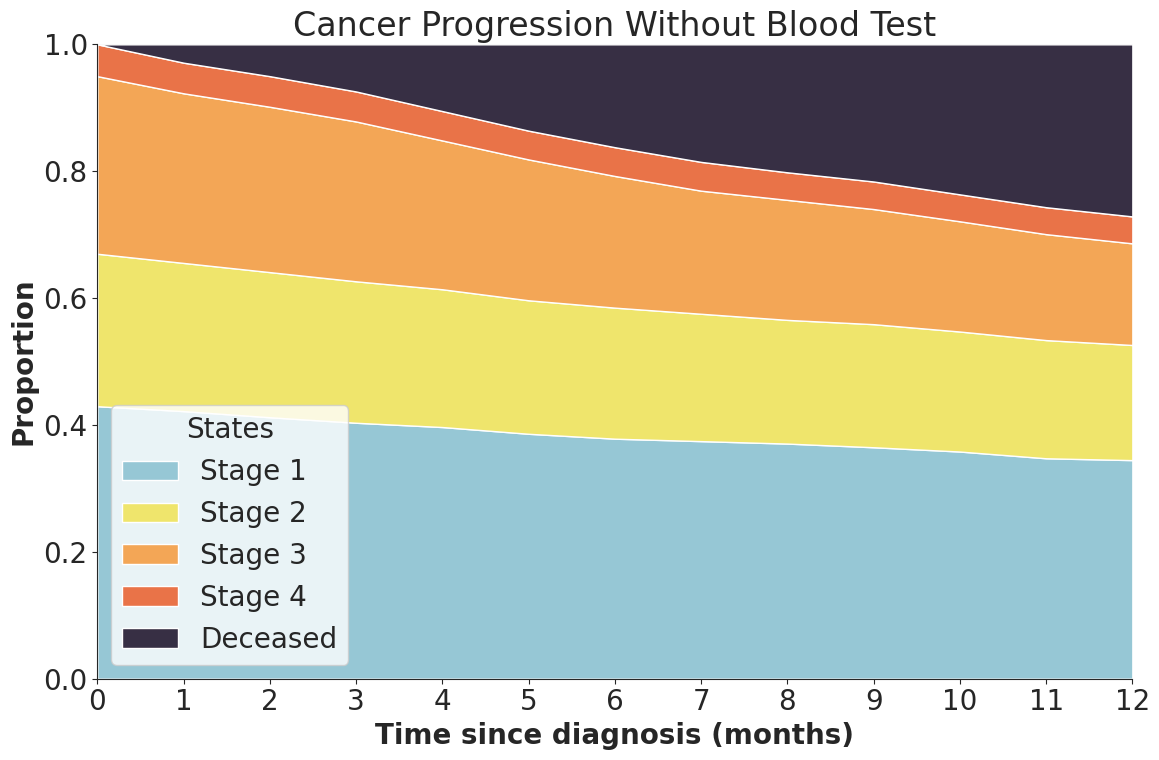

Adding 9 deceased patients at time 1.0 for blood test =  Cancer Progression With Blood Test
Adding 33 deceased patients at time 2.0 for blood test =  Cancer Progression With Blood Test
Adding 48 deceased patients at time 3.0 for blood test =  Cancer Progression With Blood Test
Adding 66 deceased patients at time 4.0 for blood test =  Cancer Progression With Blood Test
Adding 88 deceased patients at time 5.0 for blood test =  Cancer Progression With Blood Test
Adding 113 deceased patients at time 6.0 for blood test =  Cancer Progression With Blood Test
Adding 127 deceased patients at time 7.0 for blood test =  Cancer Progression With Blood Test
Adding 141 deceased patients at time 8.0 for blood test =  Cancer Progression With Blood Test
Adding 161 deceased patients at time 9.0 for blood test =  Cancer Progression With Blood Test
Adding 188 deceased patients at time 10.0 for blood test =  Cancer Progression With Blood Test
Adding 206 deceased patients at time 11.0 for blood test =  Cance

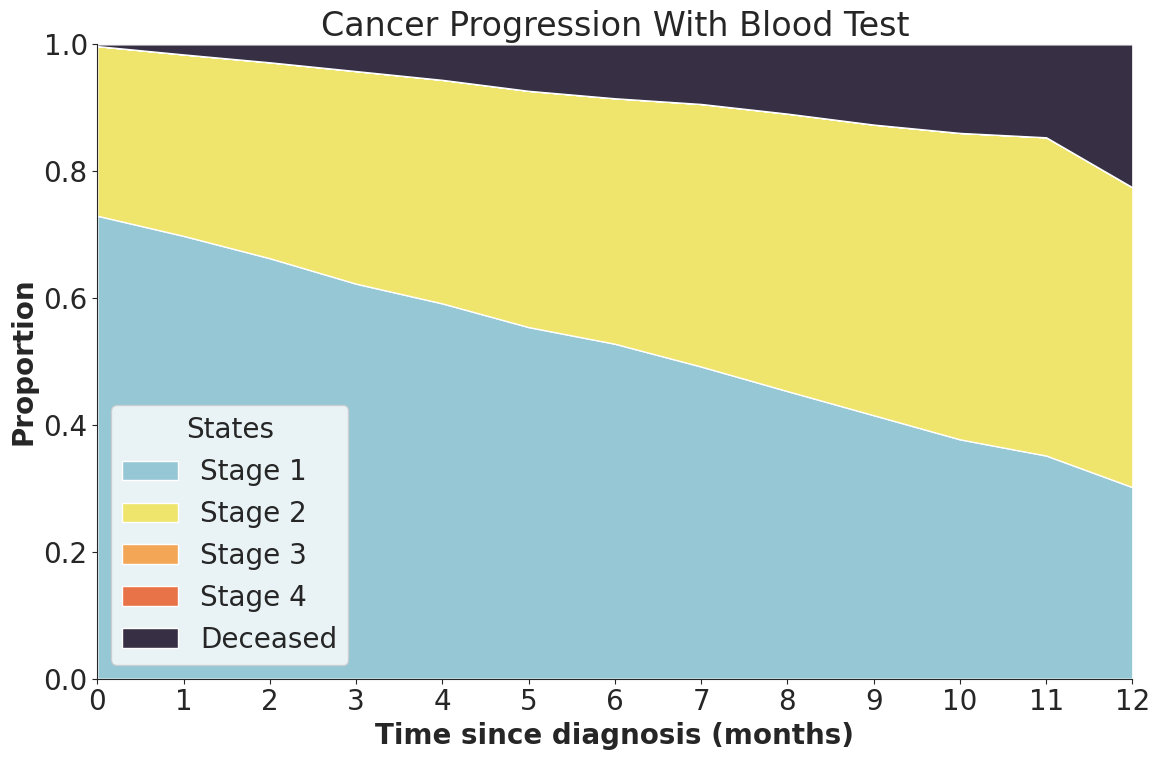

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from data_prep import align_to_diagnosis
import seaborn as sns
sns.set_style('ticks')

def create_stacked_area_chart(df, title, save_path=None):
    # Align data to diagnosis point
    aligned_df = align_to_diagnosis(df)
    
    # Ensure all columns are numeric
    for col in aligned_df.columns:
        if aligned_df[col].dtype == 'object':
            aligned_df[col] = pd.to_numeric(aligned_df[col], errors='coerce')
    
    # Remove any rows with NaN values
    aligned_df = aligned_df.dropna()
    
    # Process the aligned data
    time_points = sorted(aligned_df['adjusted_time'].unique())
    states = sorted(aligned_df['target_state'].unique())
    
    initial_states_count = len(aligned_df[aligned_df['adjusted_time'] == 0]['target_state'])
    # Create a DataFrame to hold the proportions
    proportions = pd.DataFrame(index=time_points, columns=states)
    
    # Calculate proportions for each state at each time point
    for time in time_points:
        time_slice = aligned_df[aligned_df['adjusted_time'] == time]
        state_counts = time_slice['target_state'].value_counts()
        total = len(time_slice['sample_id'].unique())
        # for the difference between current total and initial total, fill with state 5 (death)
        diff = initial_states_count - total
        
        if diff > 0:
            state_counts[5] = state_counts.get(5, 0) + diff
            print('Adding', diff, 'deceased patients at time', time, 'for blood test = ', title)
        for state in states:
            proportions.loc[time, state] = state_counts.get(state, 0) / initial_states_count
            
    proportions.to_csv('proportions_temp.csv')
    
    proportions = pd.read_csv('proportions_temp.csv', header=None, index_col=0)
    
    # Create the stacked area plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # increase font size
    plt.rcParams.update({'font.size': 20})
    # make it bold 
    plt.rcParams['axes.labelweight'] = 'bold'
    
    
    # Custom color palette
    colors = ['#96C7D5', '#EFE56C', '#F3A656', '#E97348', '#372F44']
    print(colors)
    
    colors = []#.reshape(5,3)
    #use hex color
    colors.append((150, 199, 213))
    colors.append((239, 229, 108))
    colors.append((243, 166, 86))
    colors.append((233, 115, 72))
    colors.append((55, 47, 68))
    
    colors = np.array(colors) / 255
    # 
    # convert colors to use with matplotlib
    # colors = [tuple(color) for color in colors]
    # print(matplo)
    print(colors)
    
    # delete first row in proportions
    proportions = proportions.iloc[1:]
    
    month = 12
    month = month + 1
    # cut off at 5 years
    proportions = proportions.iloc[:month]
    
    
    
    print(proportions)
    
    # rename states
    states = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Deceased']
    
    ax.stackplot(proportions.index, proportions.T, labels=states, colors=colors)
    
    # Customize the plot
    ax.set_xlabel('Time since diagnosis (months)')
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    # ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
    # put legend inside the plot on the bottom left
    ax.legend(title='States', loc='lower left')
    ax.set_xlim(0, month - 1)
    ax.set_ylim(0, 1)
    
    # set x ticks
    ax.set_xticks(np.arange(0, month, 1))
    # set x tick labels
    ax.set_xticklabels(np.arange(0, month, 1))
    # Add gridlines
    ax.grid(True, alpha=0.3)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.show()
    return proportions, aligned_df

# Assuming df_without_test and df_with_test are your DataFrames
proportions_without, aligned_without = create_stacked_area_chart(df_without_test, "Cancer Progression Without Blood Test", save_path='figures/cancerProgressionWithoutBloodtest.pdf')
proportions_with, aligned_with = create_stacked_area_chart(df_with_test, "Cancer Progression With Blood Test", save_path='figures/cancerProgressionWithBloodtest.pdf')

In [24]:
df_with_test.head()

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,36,0,1,0,55.5,66,67
1,36,1,1,1,55.5,67,68
2,36,1,1,2,55.5,68,69
3,36,1,1,3,55.5,69,70
4,36,1,1,4,55.5,70,71


In [25]:
# plot 2 year Overall survival with and without blood test using lifelines with number at risk and confidence interval
# using aligned_with and aligned_without

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def plot_survival_curves(aligned_df_with, aligned_df_without):
    # filter for only deceased patients
    # aligned_df_with = aligned_df_with[aligned_df_with['target_state'] == 5]
    # aligned_df_without = aligned_df_without[aligned_df_without['target_state'] == 5]
    
    # filter for only 1 years
    aligned_df_with = aligned_df_with[aligned_df_with['months_since_diagnosis'] <= 12]
    aligned_df_without = aligned_df_without[aligned_df_without['months_since_diagnosis'] <= 12]
    
    # Create a KaplanMeierFitter object
    kmf_with = KaplanMeierFitter()
    kmf_without = KaplanMeierFitter()

    # Fit the data to the model
    kmf_with.fit(durations=aligned_df_with['months_since_diagnosis'], event_observed=aligned_df_with['target_state'] == 5, label='With Blood Test')
    kmf_without.fit(durations=aligned_df_without['months_since_diagnosis'], event_observed=aligned_df_without['target_state'] == 5, label='Without Blood Test')
    
    # Add 2 year OS rate with confidence interval in legend
    two_year_os_with = kmf_with.survival_function_at_times([12]).values[0]
    two_year_os_without = kmf_without.survival_function_at_times([12]).values[0]
    

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 6))
    kmf_with.plot(ax=ax, label='With Blood Test (1-year OS: {:.2f})'.format(two_year_os_with))
    kmf_without.plot(ax=ax, label='Without Blood Test (1-year OS: {:.2f})'.format(two_year_os_without))
    add_at_risk_counts(kmf_with, kmf_without, ax=ax)
    ax.set_title('Overall Survival with and without Blood Test')
    ax.set_xlabel('Months since diagnosis')
    ax.set_ylabel('Survival probability')
    
    
    # Perform log-rank test
    results = logrank_test(aligned_df_with['months_since_diagnosis'], aligned_df_without['months_since_diagnosis'], event_observed_A=aligned_df_with['target_state'] == 5, event_observed_B=aligned_df_without['target_state'] == 5)
    print(f"\nLog-rank test p-value: {results.p_value}")
    
    
    print(f"\n1-year OS with blood test: {two_year_os_with:.2f}")
    print(f"1-year OS without blood test: {two_year_os_without:.2f}")
    
    # modify labels 
    # plt.legend(['With Blood Test', 'Without Blood Test'])
    # plt.legend(['With Blood Test (2-year OS: {:.2f})'.format(two_year_os_with), 'Without Blood Test (2-year OS: {:.2f})'.format(two_year_os_without)])
    # Add p value to legend
    
    # ax.legend(['With Blood Test (1-year OS: {:.2f})'.format(two_year_os_with), 'Without Blood Test (1-year OS: {:.2f})'.format(two_year_os_without)])
    ax.plot([], [], ' ', label=f'p-value: {results.p_value:.2f}')
    
    plt.savefig('figures/overallSurvivalWithAndWithoutBloodTest.pdf', dpi=600)
    
    # ax.legend(title='Blood Test')
    plt.show()

    # Print median survival times
    median_survival_with = median_survival_times(kmf_with)
    median_survival_without = median_survival_times(kmf_without)
    print(f"Median survival time with blood test: {median_survival_with:.2f} months")
    print(f"Median survival time without blood test: {median_survival_without:.2f} months")

    
    
    
    
    


Log-rank test p-value: 0.921299820306196

1-year OS with blood test: 0.97
1-year OS without blood test: 0.98


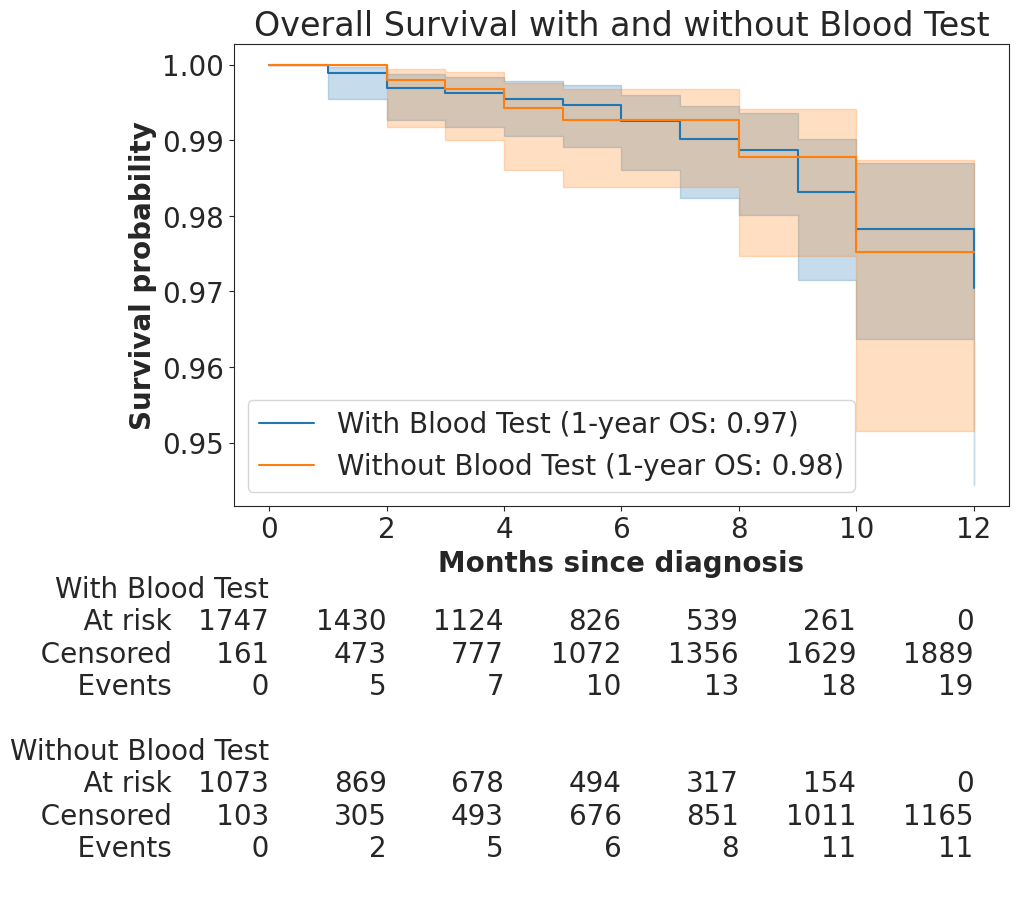

Median survival time with blood test: inf months
Median survival time without blood test: inf months


In [26]:
plot_survival_curves(aligned_with, aligned_without)